# Project: Cardiovascular Disease Prediction

This project builds a data-driven system to predict the 10‑year risk of Coronary Heart Disease (CHD) using clinical and demographic variables from the Framingham Heart Study–style dataset. The goal is to support preventive care by identifying individuals at elevated risk early.

Problem Framing
- Type: Binary classification
- Business/clinical priority: Minimize false negatives (missed CHD cases)
- Primary metric: Recall-focused evaluation; threshold chosen to maximize F2 (recall weighted)

Notebook Structure
- Imports and setup
- Data loading and cleaning
- Data understanding and cleaning: handle missing values, encode categorical variables, correct dtypes.
- Preprocessing pipeline: median/mode imputation,
- EDA: distributions, imbalance assessment, and correlation insights.
- Feature preparation and modeling
- Threshold optimization and evaluation
- Key findings and improvements

### 1. Import librairies

In [292]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.feature_selection import chi2
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, fbeta_score, recall_score

from prettytable import PrettyTable

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set() 

### 2. Import the data

In [293]:
df = pd.read_csv('train.csv', index_col=0)

### 3. Understand the data

In [294]:
df.head()

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
id,,,,,,,,,,,,,,,,
0,64,2.0,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1
1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


In [295]:
df.tail()

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
id,,,,,,,,,,,,,,,,
3385,60,1.0,F,NO,0.0,0.0,0,0,0,261.0,123.5,79.0,29.28,70.0,103.0,0
3386,46,1.0,F,NO,0.0,0.0,0,0,0,199.0,102.0,56.0,21.96,80.0,84.0,0
3387,44,3.0,M,YES,3.0,0.0,0,1,0,352.0,164.0,119.0,28.92,73.0,72.0,1
3388,60,1.0,M,NO,0.0,NaN,0,1,0,191.0,167.0,105.0,23.01,80.0,85.0,0
3389,54,3.0,F,NO,0.0,0.0,0,0,0,288.0,124.0,77.0,29.88,79.0,92.0,0


- Dataset rows and columns

In [296]:
df.shape

(3390, 16)

The dataset contains 16 columns (features) and 3390 rows (observations)

- Dataset info

In [297]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3390 entries, 0 to 3389
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              3390 non-null   int64  
 1   education        3303 non-null   float64
 2   sex              3390 non-null   object 
 3   is_smoking       3390 non-null   object 
 4   cigsPerDay       3368 non-null   float64
 5   BPMeds           3346 non-null   float64
 6   prevalentStroke  3390 non-null   int64  
 7   prevalentHyp     3390 non-null   int64  
 8   diabetes         3390 non-null   int64  
 9   totChol          3352 non-null   float64
 10  sysBP            3390 non-null   float64
 11  diaBP            3390 non-null   float64
 12  BMI              3376 non-null   float64
 13  heartRate        3389 non-null   float64
 14  glucose          3086 non-null   float64
 15  TenYearCHD       3390 non-null   int64  
dtypes: float64(9), int64(5), object(2)
memory usage: 450.2+ KB


The dataset primarily consists of float data types, along with a few integer and object columns. The variables can be grouped into several meaningful categories:

Demographic Data:

- Sex: Patient’s gender ("M" for male, "F" for female).

- Age: Age of the patient (continuous variable; although recorded as whole numbers, age is conceptually continuous).

- Education: Patient’s education level (categorical: 1, 2, 3, or 4).

Behavioral Data:

- is_smoking: Indicates whether the patient is a current smoker ("YES" or "NO").

- Cigs Per Day: Average number of cigarettes smoked per day (treated as continuous, as fractional values are possible).

Medical History:

- BP Meds: Indicates whether the patient is on blood pressure medication (nominal).

- Prevalent Stroke: Whether the patient has previously had a stroke (nominal).

- Prevalent Hyp: Whether the patient has a history of hypertension (nominal).

- Diabetes: Whether the patient has diabetes (nominal).

Current Medical Data:

- Tot Chol: Total cholesterol level (continuous).

- Sys BP: Systolic blood pressure (continuous).

- Dia BP: Diastolic blood pressure (continuous).

- BMI: Body Mass Index (continuous).

- Heart Rate: Heart rate (treated as continuous due to a large range of possible values).

- Glucose: Blood glucose level (continuous).

Target Variable> TenYearCHD: Binary variable indicating 10-year risk of coronary heart disease (1 = Yes, 0 = No).

- Checking duplicates

In [298]:
len(df[df.duplicated()])

0

We did not find any duplicates in this dataset

- Checking missing values/null values

In [299]:
df.isnull().sum()

age                  0
education           87
sex                  0
is_smoking           0
cigsPerDay          22
BPMeds              44
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             38
sysBP                0
diaBP                0
BMI                 14
heartRate            1
glucose            304
TenYearCHD           0
dtype: int64

In [300]:
df.isna().sum().sum()

np.int64(510)

There are a total of 510 missing values in the dataset across 7 features/columns

- Visualizing the missing values

<Axes: ylabel='id'>

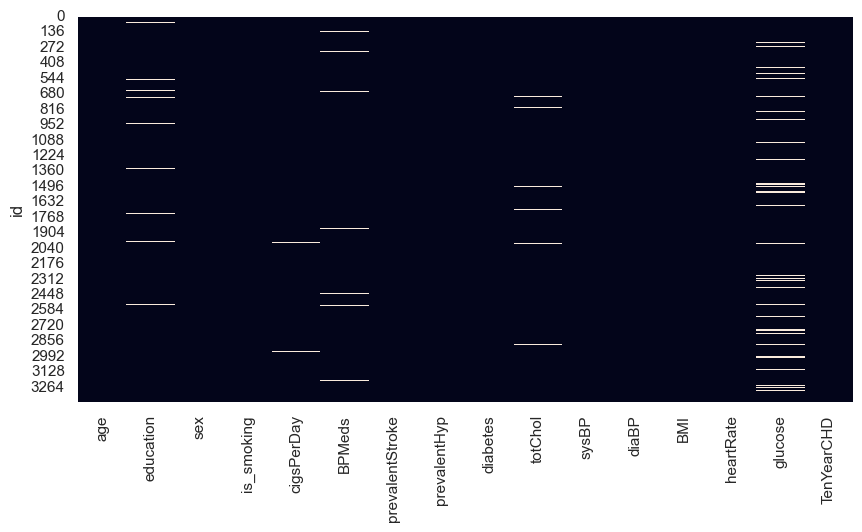

In [301]:
plt.figure(figsize=(10,5))
sns.heatmap(df.isnull(), cbar=False)

### 4. Data cleaning

In [302]:
df.columns

Index(['age', 'education', 'sex', 'is_smoking', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'],
      dtype='object')

In [303]:
df.describe(include='all')

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3390.000000,3303.000000,3390,3390,3368.000000,3346.000000,3390.000000,3390.000000,3390.000000,3352.000000,3390.00000,3390.000000,3376.000000,3389.000000,3086.000000,3390.000000
unique,NaN,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,F,NO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,1923,1703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,49.542183,1.970936,NaN,NaN,9.069477,0.029886,0.006490,0.315339,0.025664,237.074284,132.60118,82.883038,25.794964,75.977279,82.086520,0.150737
std,8.592878,1.019081,NaN,NaN,11.879078,0.170299,0.080309,0.464719,0.158153,45.247430,22.29203,12.023581,4.115449,11.971868,24.244753,0.357846
min,32.000000,1.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.50000,48.000000,15.960000,45.000000,40.000000,0.000000
25%,42.000000,1.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.00000,74.500000,23.020000,68.000000,71.000000,0.000000
50%,49.000000,2.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.50000,82.000000,25.380000,75.000000,78.000000,0.000000
75%,56.000000,3.000000,NaN,NaN,20.000000,0.000000,0.000000,1.000000,0.000000,264.000000,144.00000,90.000000,28.040000,83.000000,87.000000,0.000000


- Column renaming

We will rename the columns for consistency

In [304]:
df.rename(columns={'cigsPerDay':'cigs_per_day','BPMeds':'bp_meds',
                   'prevalentStroke':'prevalent_stroke','prevalentHyp':'prevalent_hyp',
                   'totChol':'total_cholesterol','sysBP':'systolic_bp','diaBP':'diastolic_bp',
                   'BMI':'bmi','heartRate':'heart_rate','TenYearCHD':'ten_year_chd'},
          inplace = True)

Let’s examine the unique values for each variable to support variable classification. The number of unique values helps distinguish between categorical and continuous features:
- Variables with few unique values (e.g., 2–4) are likely categorical and suitable for one-hot encoding.
- Variables with many unique values are likely continuous and require standardization or scaling.

This analysis guides the appropriate preprocessing approach for each variable type.

In [305]:
for i in df.columns.tolist():
  print("Unique values in",i,":",df[i].nunique())

Unique values in age : 39
Unique values in education : 4
Unique values in sex : 2
Unique values in is_smoking : 2
Unique values in cigs_per_day : 32
Unique values in bp_meds : 2
Unique values in prevalent_stroke : 2
Unique values in prevalent_hyp : 2
Unique values in diabetes : 2
Unique values in total_cholesterol : 240
Unique values in systolic_bp : 226
Unique values in diastolic_bp : 142
Unique values in bmi : 1259
Unique values in heart_rate : 68
Unique values in glucose : 132
Unique values in ten_year_chd : 2


Next, we’ll divide the dataset columns into three lists according to their data type and modeling role. This step prepares the data for specific preprocessing tasks that will be applied later in the project.

We will define three lists containing column names for:
- Dependent variable(s)
- Continuous independent variables
- Categorical independent variables

The classification is determined based on the number of unique values for each attribute.

This approach ensures correct preprocessing by distinguishing variable types—preventing scaling of categorical features (like education levels) and unnecessary one-hot encoding of continuous ones. It allows appropriate handling, such as median imputation for continuous variables (robust to outliers) and mode imputation for categorical ones, making the code cleaner, reusable, and easier to maintain.

In [306]:
dependent_var = ['ten_year_chd']
continuous_var = ['age','cigs_per_day','total_cholesterol','systolic_bp', 'diastolic_bp', 'bmi', 'heart_rate', 'glucose']
categorical_var = ['education', 'sex', 'is_smoking','bp_meds','prevalent_stroke', 'prevalent_hyp', 'diabetes']

Next, we’ll encode the binary columns to convert text labels into numeric values. This step is essential because most machine learning algorithms require numerical input—text values like “M” or “F” cannot be processed directly, whereas numeric representations (0 and 1) can be used seamlessly.

In [307]:
df['sex'] = np.where(df['sex'] == 'M',1,0)
df['is_smoking'] = np.where(df['is_smoking'] == 'YES',1,0)

Next, we’ll handle missing values across features.

This is an essential step since most ML algorithms can’t process NaN values. Deleting rows would waste valuable data (only 3,390 records) and worsen class imbalance, reducing model reliability. In healthcare datasets, missing data is common due to unperformed tests or entry gaps, so imputing values allows us to retain information and make predictions realistically, just as clinicians do in practice.

First we will start by replacing the missing values in the categorical columns with the most frequent entry (mode)

In [308]:
df['education'] = df['education'].fillna(df['education'].mode()[0])
df['bp_meds'] = df['bp_meds'].fillna(df['bp_meds'].mode()[0])

Education distribution after mode imputation

In [309]:
df.education.value_counts()

education
1.0    1478
2.0     990
3.0     549
4.0     373
Name: count, dtype: int64

bp_meds distribution after mode imputation

In [310]:
df.bp_meds.value_counts()

bp_meds
0.0    3290
1.0     100
Name: count, dtype: int64

Data cleaning: cigs per day

Mean and median number of cigarettes per day

In [311]:
df.cigs_per_day.mean().round(0),df.cigs_per_day.median()

(np.float64(9.0), np.float64(0.0))

Let's check all missing values in the cigs_per_day column

In [312]:
df[df['cigs_per_day'].isna()]

,age,education,sex,is_smoking,cigs_per_day,bp_meds,prevalent_stroke,prevalent_hyp,diabetes,total_cholesterol,systolic_bp,diastolic_bp,bmi,heart_rate,glucose,ten_year_chd
id,,,,,,,,,,,,,,,,
422,55,1.0,0,1,NaN,0.0,0,1,0,213.0,163.0,91.0,28.66,69.0,66.0,0
466,45,3.0,1,1,NaN,0.0,0,1,0,170.0,145.5,99.0,26.74,83.0,85.0,0
469,42,1.0,1,1,NaN,0.0,0,0,0,196.0,123.0,73.0,22.06,66.0,NaN,0
491,61,1.0,0,1,NaN,0.0,0,1,0,356.0,168.0,98.0,27.30,103.0,106.0,0
538,41,1.0,0,1,NaN,0.0,0,0,0,171.0,135.0,82.5,24.35,79.0,82.0,0
767,54,1.0,1,1,NaN,0.0,0,0,0,219.0,110.0,72.0,26.05,95.0,86.0,0
1461,47,2.0,0,1,NaN,0.0,0,0,0,365.0,127.0,76.0,24.44,72.0,80.0,0
1467,49,1.0,0,1,NaN,0.0,0,0,0,252.0,123.0,69.0,21.45,72.0,89.0,0
1597,57,1.0,0,1,NaN,0.0,0,0,0,229.0,115.0,69.0,24.43,80.0,93.0,0


From the above table, we find that for every instance of missing values in cigs per day, the patients reported that they smoke.

Let's check the mean and median number of cigarettes smoked by patients, who reported that they smoke.

In [313]:
df[df['is_smoking']==1]['cigs_per_day'].mean(),df[df['is_smoking']==1]['cigs_per_day'].median()   

(np.float64(18.345945945945946), np.float64(20.0))

We find that the mean number of cigarettes for a smoker is 18.34 and the median number of cigarettes for a smoker is 20

Let's find the distribution of number of cigarettes per day for smokers (excluding non-smokers)

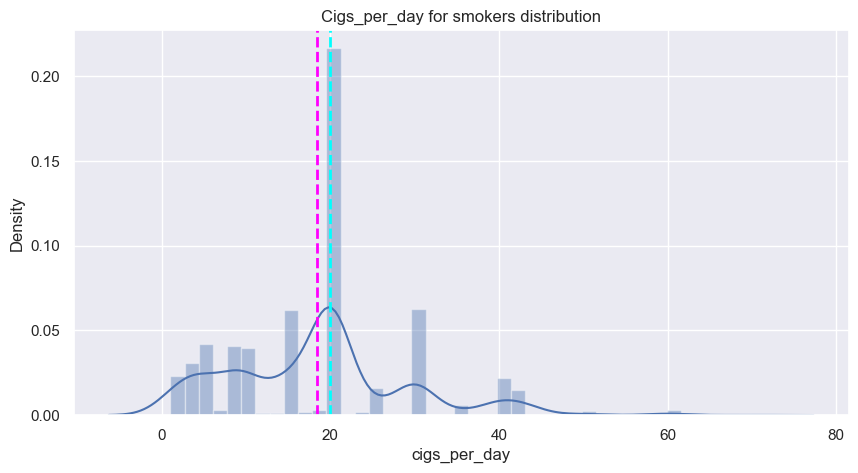

In [314]:
plt.figure(figsize=(10,5))
sns.distplot(df[df['is_smoking']==1]['cigs_per_day'])
plt.axvline(df[df['is_smoking']==1]['cigs_per_day'].mean(), color='magenta', linestyle='dashed', linewidth=2)
plt.axvline(df[df['is_smoking']==1]['cigs_per_day'].median(), color='cyan', linestyle='dashed', linewidth=2)
plt.title('Cigs_per_day for smokers distribution')
plt.show()

Let's create a boxlot for the number of cigarettes per day for smokers (excluding non-smokers)

<Axes: ylabel='cigs_per_day'>

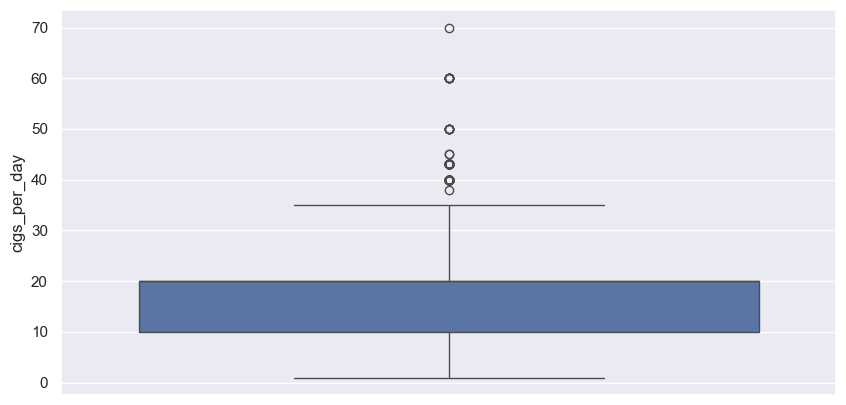

In [315]:
plt.figure(figsize=(10,5))
sns.boxplot(df[df['is_smoking']==1]['cigs_per_day'])

Since the number of cigarettes smoked by the patients who smoke contains outliers, let's impute the missing values in ths cigs_per_day column with its median value.

In [316]:
df['cigs_per_day'] = df['cigs_per_day'].fillna(df[df['is_smoking']==1]['cigs_per_day'].median())

Let's check for any wrong entries where the patient is not a smoker and cigarettes per day above 0

In [317]:
df[(df['is_smoking']==0) & (df['cigs_per_day']>0)]

,age,education,sex,is_smoking,cigs_per_day,bp_meds,prevalent_stroke,prevalent_hyp,diabetes,total_cholesterol,systolic_bp,diastolic_bp,bmi,heart_rate,glucose,ten_year_chd
id,,,,,,,,,,,,,,,,


Data cleaning: total_cholestrol, bmi, heart_rate:

Let's check the distribution of the total_cholesterol, bmi, and heart_rate

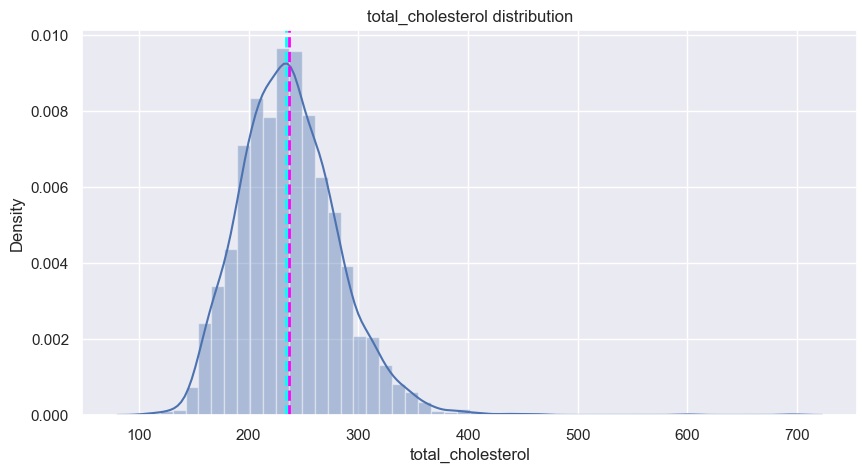

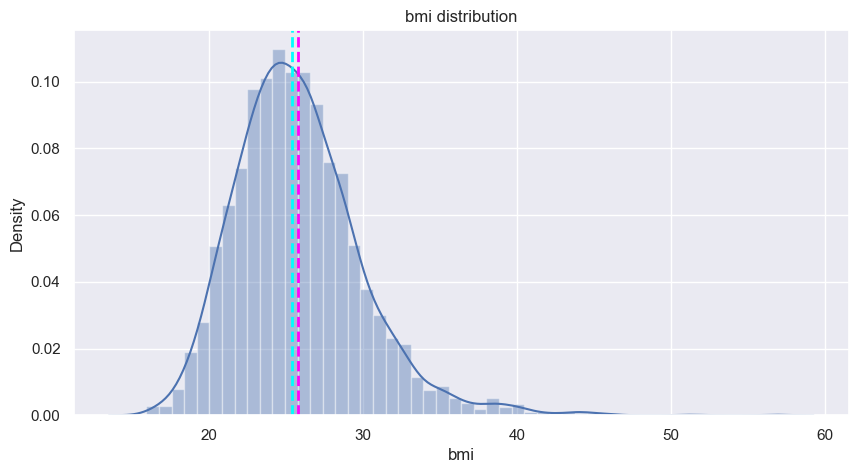

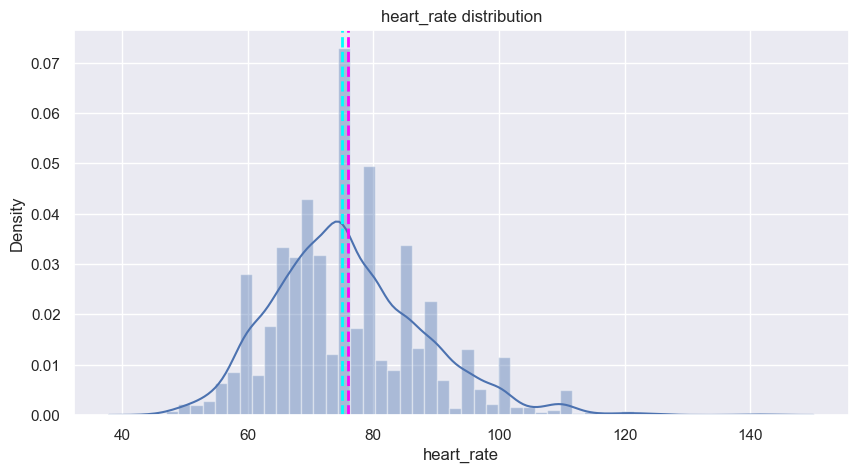

In [318]:
for i in ['total_cholesterol','bmi','heart_rate']:
  plt.figure(figsize=(10,5))
  sns.distplot(df[i])
  plt.axvline(df[i].mean(), color='magenta', linestyle='dashed', linewidth=2)
  plt.axvline(df[i].median(), color='cyan', linestyle='dashed', linewidth=2)
  plt.title(i+' distribution')
  plt.show()

The total_cholestrol, bmi, and heart_rate columns are positively skewed

Let's check for outliers in total_cholesterol, bmi, heart_rate columns

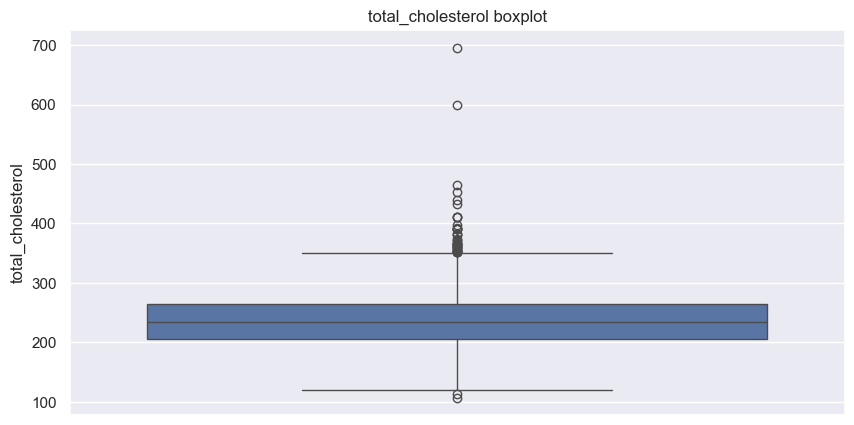

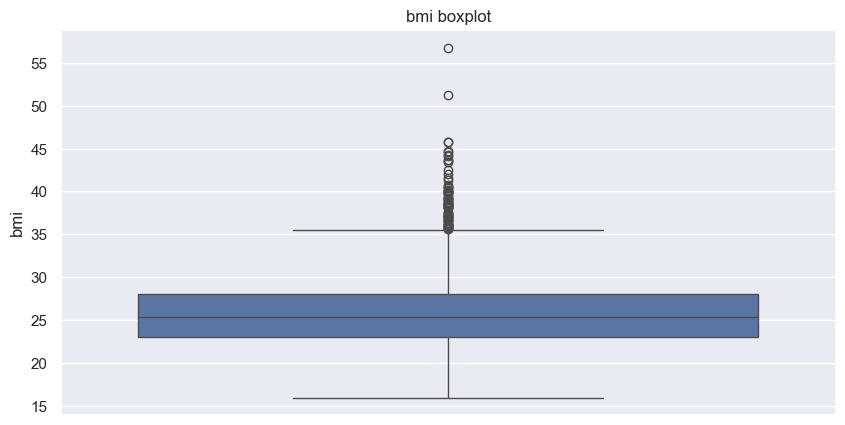

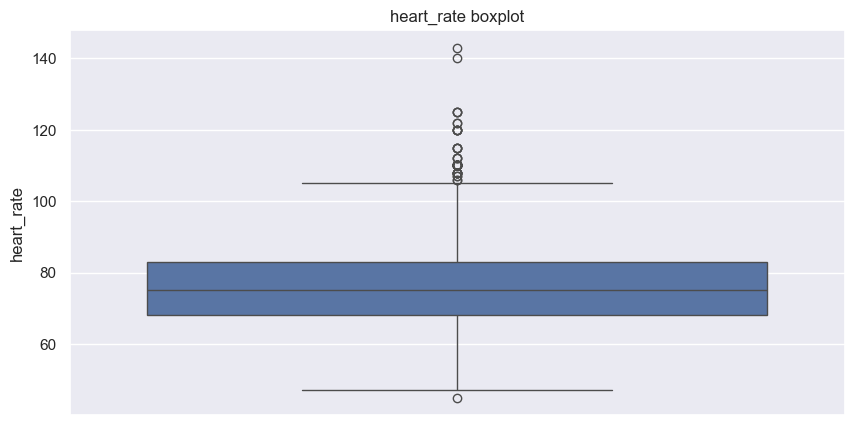

In [319]:
for i in ['total_cholesterol','bmi','heart_rate']:
  plt.figure(figsize=(10,5))
  sns.boxplot(df[i])
  plt.title(i+' boxplot')
  plt.show()

The total_cholestrol, bmi, and heart_rate columns contain outliers.

Let's check for the mean and median for total_cholesterol

In [320]:
df.total_cholesterol.mean(),df.total_cholesterol.median()

(np.float64(237.07428400954655), np.float64(234.0))

Let's check for the mean and median for bmi

In [321]:
df.bmi.mean(),df.bmi.median()

(np.float64(25.7949644549763), np.float64(25.38))

Let's check for mean and median for heart_rate

In [322]:
df.heart_rate.mean(),df.heart_rate.median()

(np.float64(75.97727943346119), np.float64(75.0))

Since the total_cholestrol, bmi, and heart_rate columns are positively skewed, and also contains outliers. We can impute the missing values with its median.

In [323]:
df['total_cholesterol'] = df['total_cholesterol'].fillna(df['total_cholesterol'].median())
df['bmi'] = df['bmi'].fillna(df['bmi'].median())
df['heart_rate'] = df['heart_rate'].fillna(df['heart_rate'].median())

Let's check for mean and median of total_cholesterol after median imputation

In [324]:
df.total_cholesterol.mean(),df.total_cholesterol.median()

(np.float64(237.03982300884957), np.float64(234.0))

Let's check mean and median of bmi after median imputation

In [325]:
df.bmi.mean(),df.bmi.median()

(np.float64(25.793250737463126), np.float64(25.38))

Let's check for mean and median of heart_rate after median imputation

In [326]:
df.heart_rate.mean(),df.heart_rate.median()

(np.float64(75.97699115044247), np.float64(75.0))

Data cleaning: glucose

Let's check for total missing values in glucose again

In [327]:
df.glucose.isna().sum()

np.int64(304)

The glucose column contains 304 missing values. Let's look at its distribution

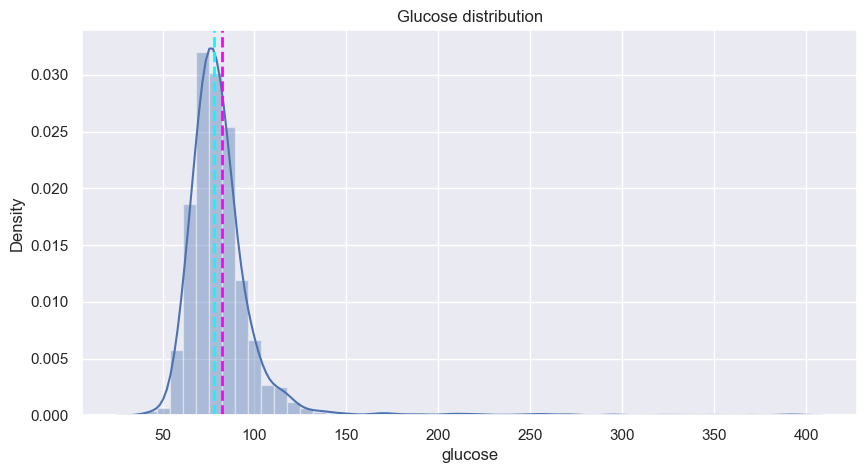

In [328]:
plt.figure(figsize=(10,5))
sns.distplot(df['glucose'])
plt.axvline(df['glucose'].mean(), color='magenta', linestyle='dashed', linewidth=2)
plt.axvline(df['glucose'].median(), color='cyan', linestyle='dashed', linewidth=2)
plt.title('Glucose distribution')
plt.show()

The glucose column is positively skewed. Let's look for outliers

Text(0.5, 1.0, 'Glucose boxplot')

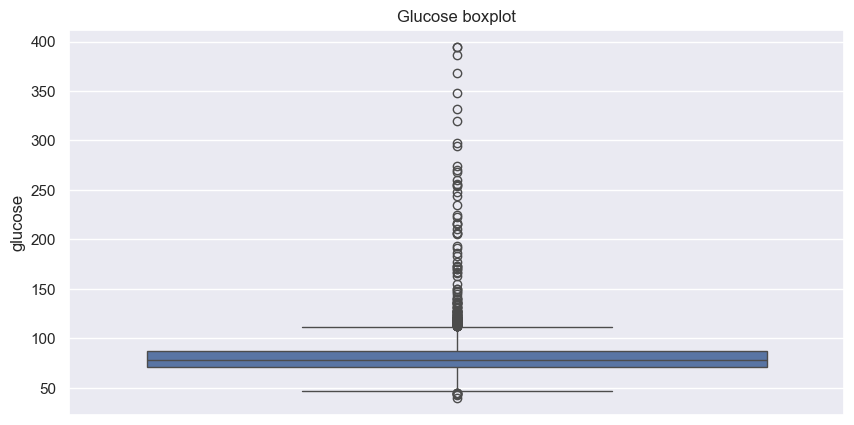

In [329]:
plt.figure(figsize=(10,5))
sns.boxplot(df['glucose'])
plt.title('Glucose boxplot')

The glucose column contains outliers. Let's check its mean, media and mode

In [330]:
df.glucose.mean(),df.glucose.median(),df.glucose.mode()

(np.float64(82.08651976668827),
 np.float64(78.0),
 0    75.0
 Name: glucose, dtype: float64)

The glucose variable is positively skewed with several outliers and 304 missing values. Imputing them with a single value (mean or median) would introduce bias, reduce variability, and distort the distribution by creating an artificial peak. Instead, KNN imputation provides patient-specific estimates by finding the most similar patients (e.g., based on age, BMI, diabetes status, blood pressure) and using their glucose values to fill in the gaps. This approach preserves natural relationships between glucose and other health factors, maintaining realistic variation and reducing bias compared to using a single global valu

In [331]:
imputer = KNNImputer(n_neighbors=10)
imputed = imputer.fit_transform(df)
df = pd.DataFrame(imputed, columns=df.columns)

Choosing K=10 neighbors offers a balance between stability and local context—fewer neighbors make the imputation too sensitive to outliers, while too many dilute patient-specific patterns toward the global mean. KNN imputation works best when many values are missing, features are interrelated (like glucose with diabetes, age, or BMI), and variation matters. In contrast, mean or median imputation is more suitable when missing data is minimal or the feature is largely independent.

Finally let's check once again mean, median, and mode for glucose after KNN imputation

In [332]:
df.glucose.mean(),df.glucose.median(),df.glucose.mode()

(np.float64(82.04327433628319),
 np.float64(78.0),
 0    75.0
 Name: glucose, dtype: float64)

After KNN imputation, there is no massive change in the values of mean. And the values of median and mode remain the same.

In [333]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                3390 non-null   float64
 1   education          3390 non-null   float64
 2   sex                3390 non-null   float64
 3   is_smoking         3390 non-null   float64
 4   cigs_per_day       3390 non-null   float64
 5   bp_meds            3390 non-null   float64
 6   prevalent_stroke   3390 non-null   float64
 7   prevalent_hyp      3390 non-null   float64
 8   diabetes           3390 non-null   float64
 9   total_cholesterol  3390 non-null   float64
 10  systolic_bp        3390 non-null   float64
 11  diastolic_bp       3390 non-null   float64
 12  bmi                3390 non-null   float64
 13  heart_rate         3390 non-null   float64
 14  glucose            3390 non-null   float64
 15  ten_year_chd       3390 non-null   float64
dtypes: float64(16)
memory us


The KNN imputer has converted all the columns to the float64 datatype. Therefore, we need to change back the column datatype accordingly as per the kind of data stored in the respective column.

In [334]:
df = df.astype({'age': int, 'education':int,'sex':int,'is_smoking':int,'cigs_per_day':int,
               'bp_meds':int,'prevalent_stroke':int,'prevalent_hyp':int,'diabetes':int,
               'total_cholesterol':float,'systolic_bp':float,'diastolic_bp':float,
               'bmi':float,'heart_rate':float,'glucose':float,'ten_year_chd':int})

As a last step, let's check for a last time the missing values

In [335]:
df.isna().sum()

age                  0
education            0
sex                  0
is_smoking           0
cigs_per_day         0
bp_meds              0
prevalent_stroke     0
prevalent_hyp        0
diabetes             0
total_cholesterol    0
systolic_bp          0
diastolic_bp         0
bmi                  0
heart_rate           0
glucose              0
ten_year_chd         0
dtype: int64

We have successfully handled all the missing values in the dataset!

### 5. Exploratory data analysis

- Distribution of the dependent variable: ten_year_chd


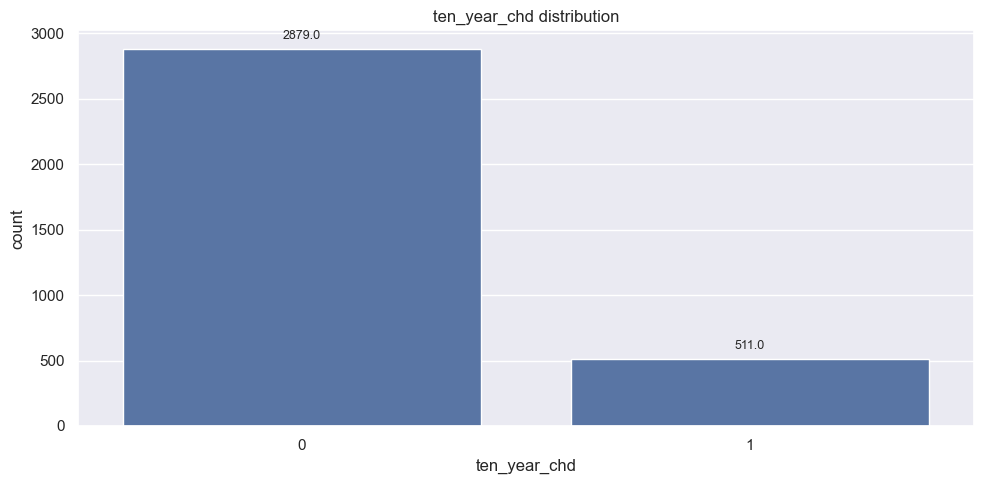

In [336]:
plt.figure(figsize=(10, 5))

col = dependent_var[0]
order = df[col].value_counts().index 

ax = sns.countplot(data=df, x=col, order=order)
ax.set_xlabel(col)
ax.set_title(f'{col} distribution')

for patch in ax.patches:
    height = patch.get_height()
    ax.annotate(f'{height}', 
                (patch.get_x() + patch.get_width() / 2.0, height),
                ha='center', va='bottom', xytext=(0, 5),
                textcoords='offset points', fontsize=9)

plt.xticks(rotation=0) 
plt.tight_layout()
plt.show()

In [337]:
df[dependent_var].value_counts()

ten_year_chd
0               2879
1                511
Name: count, dtype: int64

The dependent variable - 10-year risk of coronary heart disease is unbalanced. Only ~15% of the patients in the study were eventually exposed to the risk of this heart disease, rest of the patients were not exposed to this disease after the end of 10 year study.

- Analyzing the distribution of the continuous independent variables in the dataset:

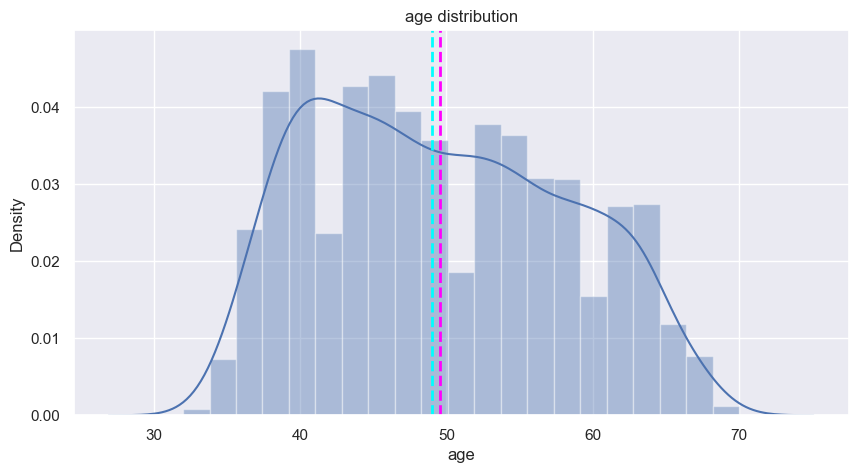

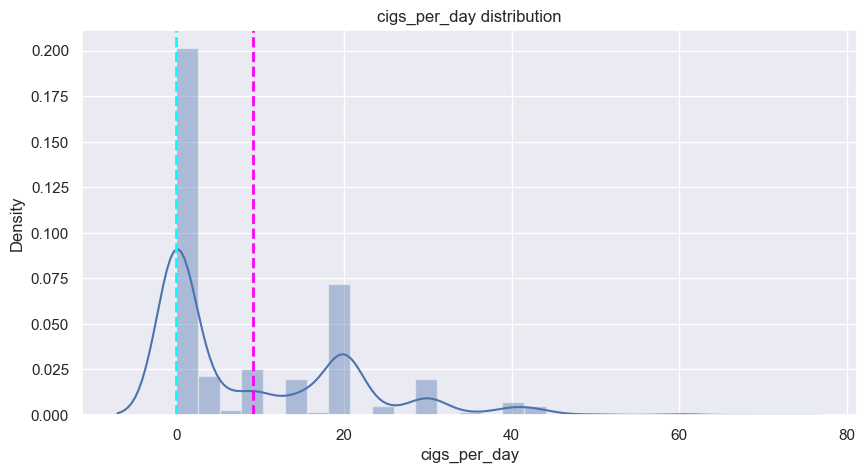

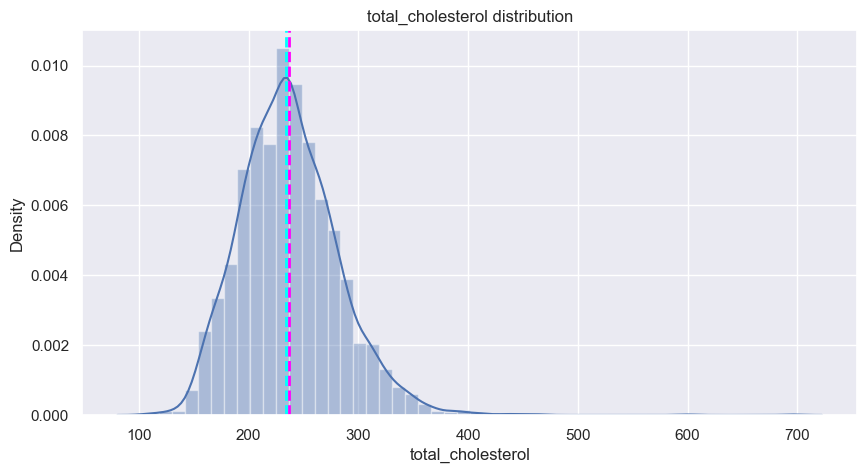

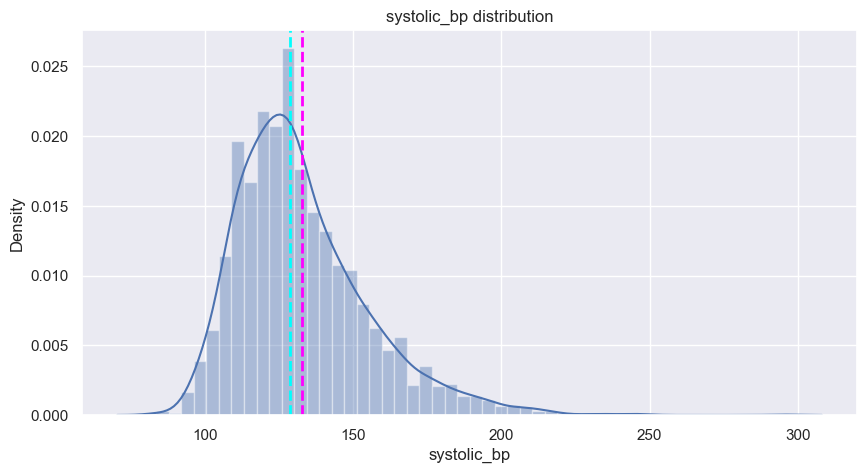

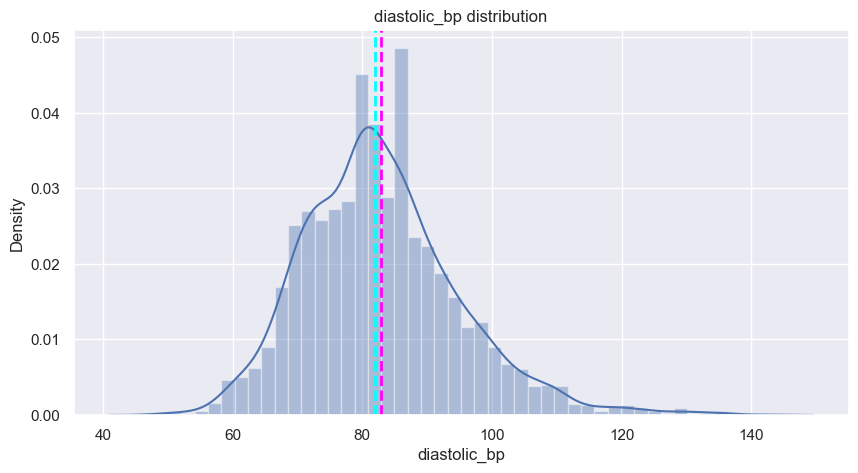

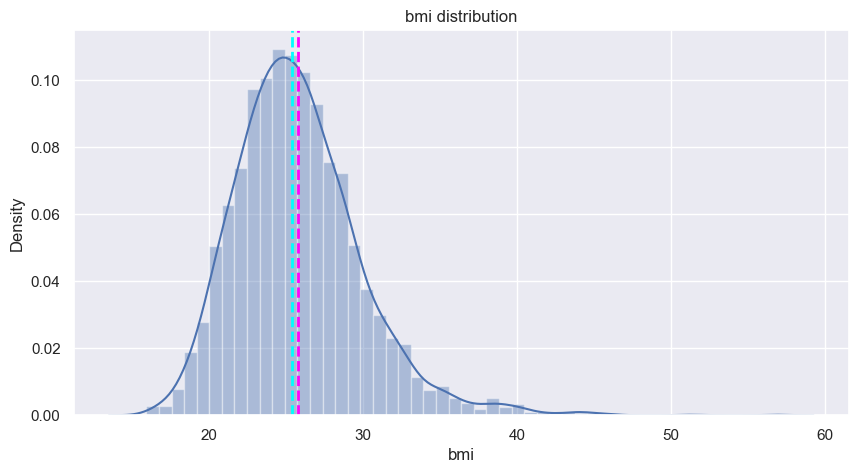

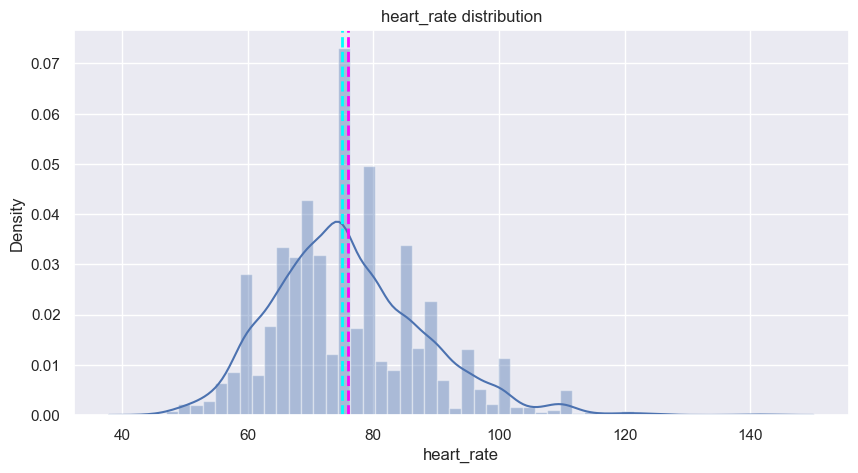

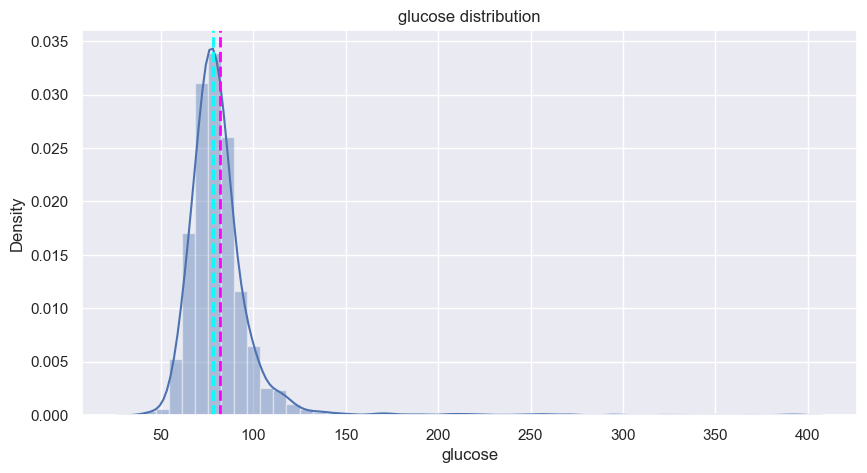

In [338]:
for col in continuous_var:
  plt.figure(figsize=(10,5))
  sns.distplot(df[col])
  plt.axvline(df[col].mean(), color='magenta', linestyle='dashed', linewidth=2)
  plt.axvline(df[col].median(), color='cyan', linestyle='dashed', linewidth=2)
  plt.title(col+' distribution')
  plt.show()

- Analyzing the distribution of the discrete/categorical independent variables:

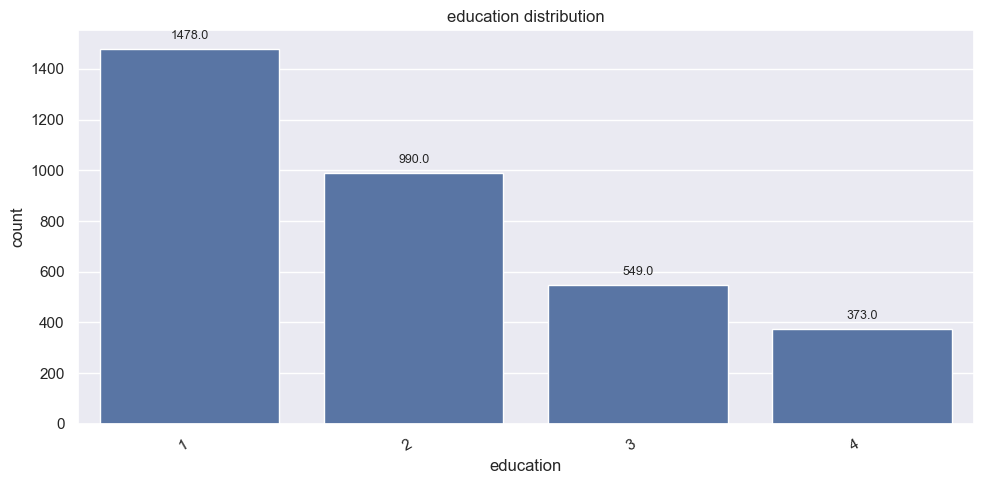

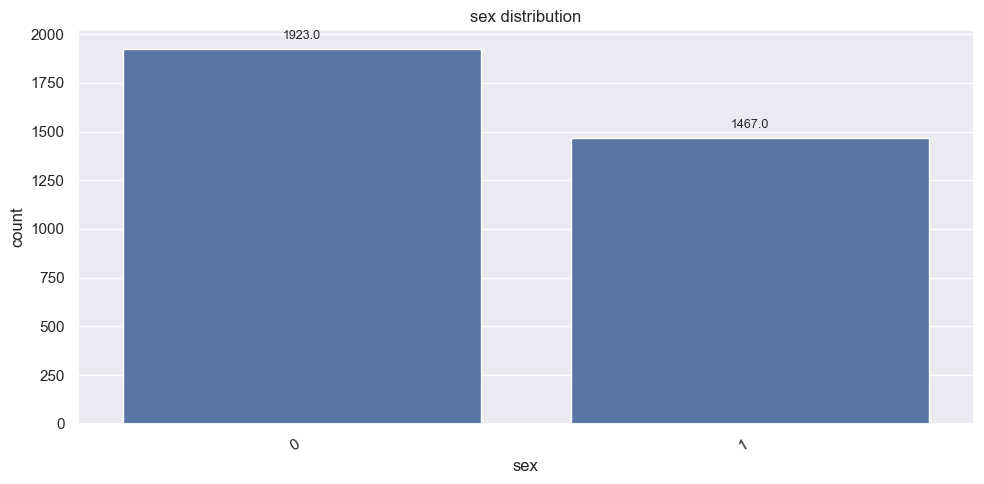

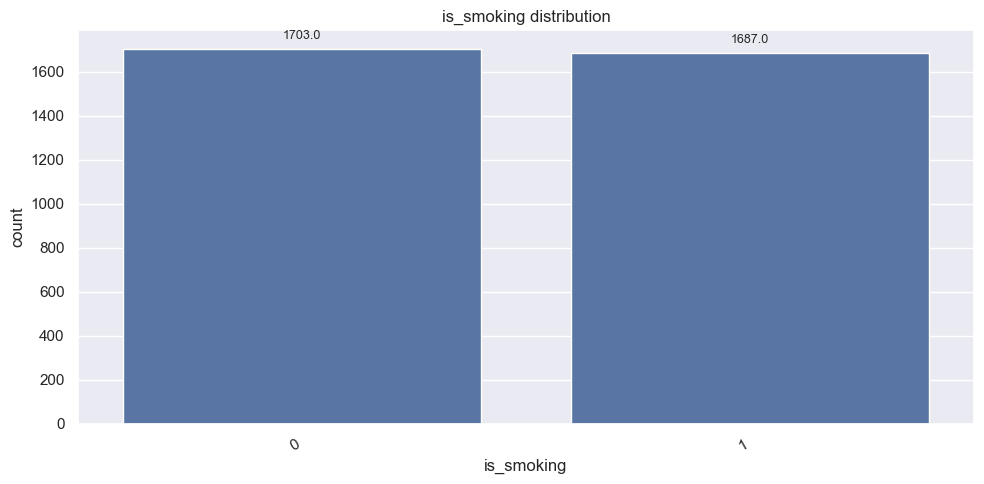

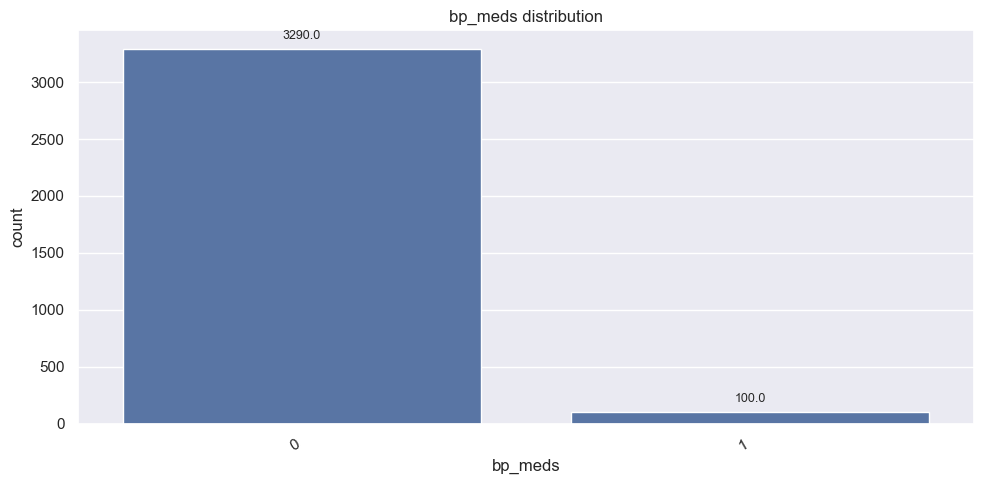

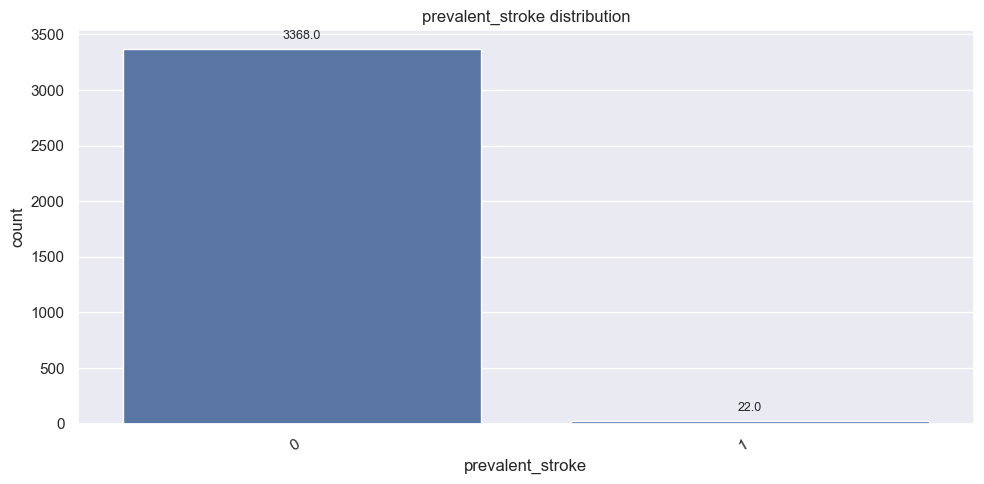

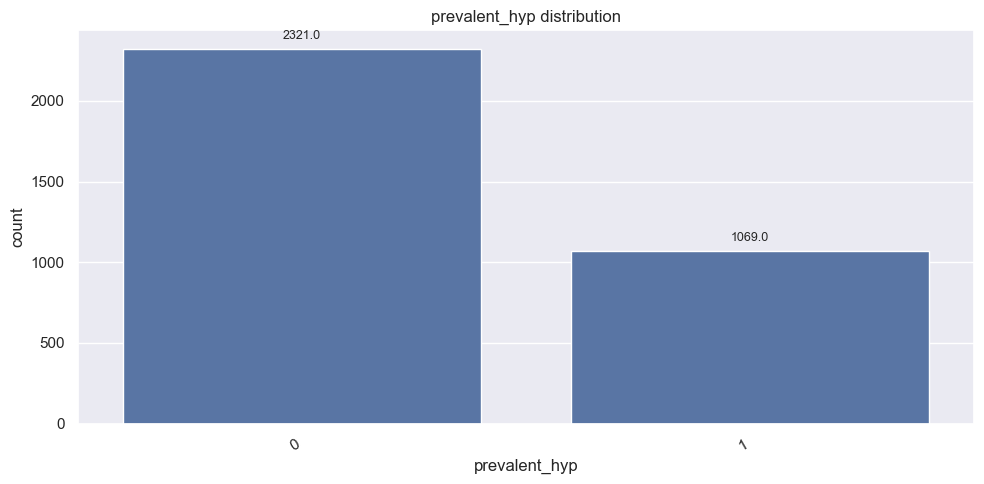

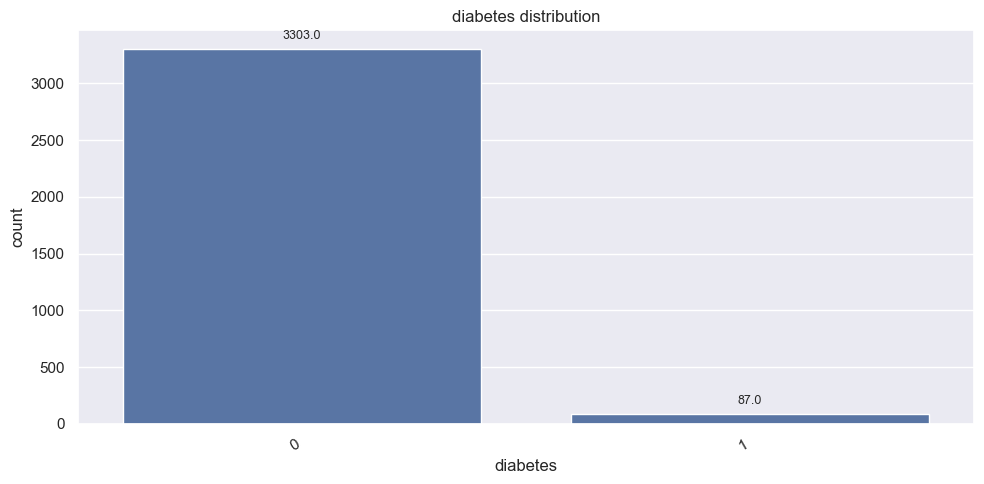

In [339]:
for col in categorical_var:
    plt.figure(figsize=(10, 5))
    order = df[col].value_counts().index

    ax = sns.countplot(data=df, x=col, order=order)
    ax.set_xlabel(col)
    ax.set_title(f'{col} distribution')

    for patch in ax.patches:
        height = patch.get_height()
        ax.annotate(f'{height}',
                    (patch.get_x() + patch.get_width() / 2.0, height),
                    ha='center', va='bottom', xytext=(0, 5), textcoords='offset points', fontsize=9)

    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()

- Correlation analysis:


<Axes: title={'center': 'Correlation Analysis'}>

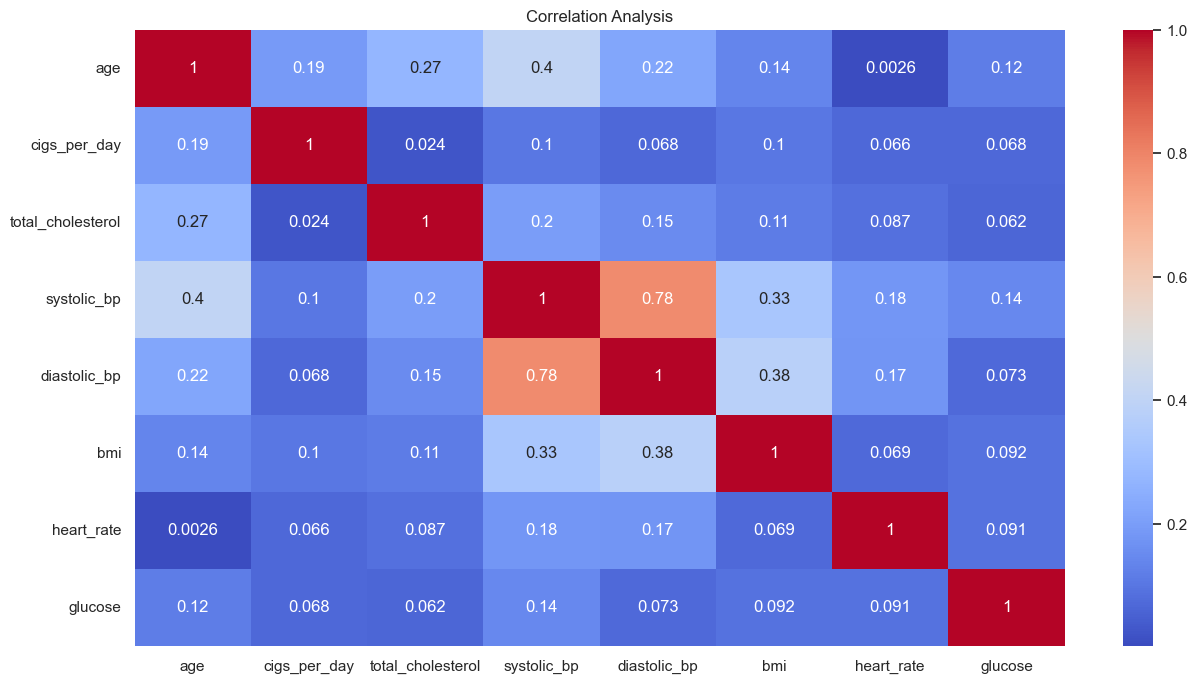

In [340]:
plt.figure(figsize=(15,8))
plt.title('Correlation Analysis')
correlation = df[continuous_var].corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')

Only Sys BP (Systolic blood pressure) and Dia BP (Diastolic blood pressure) are strongly positively correlated

### 6. Logistical regression

#### 6.1. Data Preparation and Feature Engineering
**What was done:**
- Separated the target variable (`ten_year_chd`) from predictor variables
- Automatically identified categorical and numerical features from the dataset
- Created a robust preprocessing pipeline to handle different data types appropriately

**Rationale:**
- Categorical variables require one-hot encoding for logistic regression
- Numerical variables need standardization to ensure equal feature importance
- Proper data preparation is crucial for model performance and interpretability

- Define target and features

In [341]:
TARGET_COL = 'ten_year_chd'
assert TARGET_COL in df.columns, f"Column '{TARGET_COL}' not found in df"

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].astype(int)

- Determine categorical and numeric columns

In [342]:
if 'categorical_var' in globals() and isinstance(categorical_var, (list, tuple)):
    categorical_cols = [c for c in categorical_var if c in X.columns]
else:
    categorical_cols = list(X.select_dtypes(include=['object', 'category']).columns)

numeric_cols = [c for c in X.columns if c not in categorical_cols]

#### 6.2. Model Configuration and Training Strategy

A logistic regression model was implemented using balanced class weights and a stratified 80/20 train-test split to maintain class distribution. The liblinear solver was chosen for its efficiency with small to medium datasets and compatibility with L1/L2 regularization.

This setup directly addresses key challenges:

- Class imbalance (~15% CHD cases): Using class_weight='balanced' ensures the model gives more weight to minority CHD cases, improving recall and reducing false negatives.
- Convergence issues: Setting max_iter=1000 guarantees proper training completion.
- Dataset size: The liblinear solver is optimized for smaller datasets, offering speed and stability.
- Reproducibility: A fixed random_state=42 ensures consistent, comparable results across runs.

This configuration effectively handles imbalance, prioritizes detecting CHD cases (higher recall), ensures model convergence, and maintains reproducibility, aligning with the clinical objective of minimizing missed CHD diagnoses, even at the cost of slightly more false positives.

In [343]:
logreg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',  # CHD positives are often minority; penalize FN via class balancing
    solver='liblinear',
    n_jobs=None,
    random_state=42
)

- Pipeline

Next we build a two-step pipeline combining preprocessing (imputation, encoding, scaling) with a logistic regression model. It ensures consistent preprocessing between training and prediction, prevents data leakage by fitting transformations only on the training set, and simplifies the workflow for reuse and deployment. Overall, it follows best practices that make the machine learning process more reliable, maintainable, and production-ready.

In [344]:
clf = Pipeline(steps=[('prep', preprocessor), ('model', logreg)])

- Train/test split

Afterwards, we split the data into training and test set.

This step is crucial because it prevents overfitting by using the test set to simulate unseen patients, ensuring that evaluation metrics reflect real-world performance. Stratified splitting maintains class proportions, which is essential for handling imbalance, while a fixed random_state guarantees reproducibility. In summary, the data is split into 80% training and 20% testing, preserving class distribution with stratify=y and ensuring consistent results—making this a standard and reliable practice for building robust ML pipelines.

In [345]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

- Fit

The clf.fit(X_train, y_train) step trains the full pipeline by first fitting the preprocessor (learning medians, means, standard deviations, and category mappings) and transforming the training data through imputation, encoding, and scaling. It then trains the logistic regression model, finding optimal feature coefficients that minimize prediction error while applying class balancing to better detect CHD cases. The learned preprocessing parameters and model weights are stored, enabling accurate predictions for new patients—this is the key step where raw data becomes a predictive CHD risk model.

In [346]:
clf.fit(X_train, y_train)

,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


- Get probabilities

Afterwards, we generate probability predictions using predict_proba(), which returns probabilities for both classes—[:, 1] extracts the likelihood of CHD (class 1). It produces y_train_proba for threshold tuning and y_test_proba for final evaluation. These probabilities enable threshold optimization, allowing you to adjust the cutoff to maximize metrics like the F2-score, which is crucial for recall-focused medical diagnosis. Each patient receives a continuous risk score between 0 and 1, offering more nuanced insights than binary predictions and ensuring flexibility to align the model’s decisions with clinical priorities.

In [347]:
y_train_proba = clf.predict_proba(X_train)[:, 1]
y_test_proba = clf.predict_proba(X_test)[:, 1]

#### 6.3. Optimal Threshold Selection Methodology

The model’s performance will be evaluated across multiple thresholds using the F2-score metric (β=2.0), which prioritizes recall twice as much as precision. The optimal threshold was selected based on the highest F2-score from the training data.

We will then apply the optimal threshold (0.3983) to convert probability scores into binary predictions (0 or 1) for both training and test sets. It produces y_train_pred for performance checks and y_test_pred for final evaluation. These binary outputs enable calculation of key metrics like recall, precision, and the confusion matrix. Using the optimized threshold—rather than the default 0.5—significantly improves recall, capturing 77.45% of CHD cases, which aligns with the clinical goal of identifying as many at-risk patients as possible for follow-up.

In [348]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_train_proba)
thresholds_for_eval = np.r_[0.0, thresholds]

In [349]:
beta = 2.0
f2_scores = []
for thr in thresholds_for_eval:
    y_pred_thr = (y_train_proba >= thr).astype(int)
    f2_scores.append(fbeta_score(y_train, y_pred_thr, beta=beta, zero_division=0))

best_idx = int(np.argmax(f2_scores))
optimal_threshold = float(thresholds_for_eval[best_idx])

In [350]:
y_train_pred = (y_train_proba >= optimal_threshold).astype(int)
y_test_pred = (y_test_proba >= optimal_threshold).astype(int)

**Rationale for F2-score choice:**
- **Medical context:** False negatives (missed CHD cases) are more dangerous than false positives (unnecessary treatment)
- **F2-score advantage:** Provides a single metric that balances precision and recall while heavily favoring recall
- **Clinical relevance:** Better to over-diagnose than under-diagnose in cardiovascular risk assessment

#### 6.4. Model Evaluation and Performance Metrics

Model performance was assessed using multiple evaluation tools. Recall scores were calculated for both training and test sets to measure the model’s ability to detect CHD cases. A classification report was generated, providing precision, recall, F1-score, and support for each class, offering a balanced view of performance. Additionally, a confusion matrix was created to visualize correct and incorrect predictions, enabling detailed analysis of false positives and false negatives—critical for understanding diagnostic reliability.

In [351]:
train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)

Chosen metric: F2 (beta=2.0) to emphasize recall over precision for CHD risk
Optimal threshold (train, F2-max): 0.3983
Training recall: 0.8215
Test recall: 0.7745

Test Classification Report (optimal threshold):
              precision    recall  f1-score   support

           0     0.9322    0.5486    0.6907       576
           1     0.2330    0.7745    0.3583       102

    accuracy                         0.5826       678
   macro avg     0.5826    0.6616    0.5245       678
weighted avg     0.8270    0.5826    0.6407       678



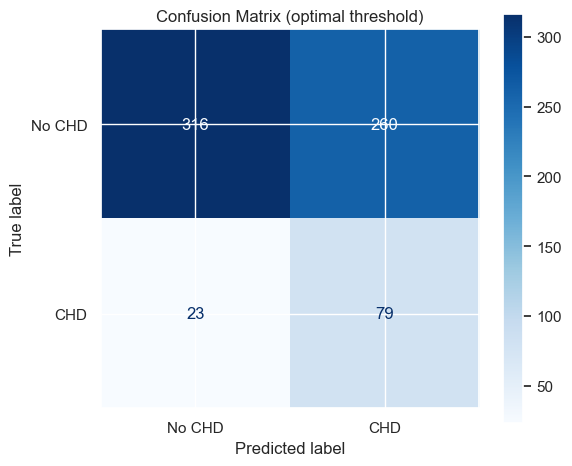

In [352]:
print(f"Chosen metric: F2 (beta={beta}) to emphasize recall over precision for CHD risk")
print(f"Optimal threshold (train, F2-max): {optimal_threshold:.4f}")
print(f"Training recall: {train_recall:.4f}")
print(f"Test recall: {test_recall:.4f}")

print("\nTest Classification Report (optimal threshold):")
print(classification_report(y_test, y_test_pred, digits=4))

fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_test_pred,
    display_labels=['No CHD', 'CHD'],
    cmap='Blues',
    values_format='d',
    ax=ax
)
ax.set_title('Confusion Matrix (optimal threshold)')
plt.tight_layout()
plt.show()


**Key Metrics Explained:**
- **Recall (Sensitivity):** Proportion of actual CHD cases correctly identified
- **Precision:** Proportion of predicted CHD cases that are actually positive
- **F1-score:** Harmonic mean of precision and recall
- **Support:** Number of actual occurrences of each class

Interpretation:
- 79 out of 102 CHD patients were correctly identified
- 77.45% of CHD cases were caught
- 23 cases were missed (false negatives)

High recall means:
- You catch most CHD cases
- Fewer false negatives (missed diagnoses)
- More lives potentially saved

### 7. Findings Summary and Improvements

7.1 Key Findings Summary

- Data: The dataset includes 3,390 patients with 16 clinical and demographic variables and a strong class imbalance (~15% CHD cases). Missing values (510 across 7 features) were imputed appropriately using median, mode, and KNN methods.

- Model: Logistic regression optimized for the F2-score (β=2.0) achieved an optimal threshold of 0.3983, improving recall to 77.45% while maintaining acceptable overfitting (training recall 82.15%). Precision was 23.3%, and the F1-score for CHD was 35.83%.

- Clinical relevance: The model missed only 22.5% of CHD cases but flagged some false positives (45%), favoring higher sensitivity—appropriate for early detection and preventive care.

- Features: Domain-based preprocessing, proper scaling and encoding, and class balancing with class_weight='balanced' ensured reliable and clinically aligned model performance.


7.2 Improvements

- Model Architecture

Ensemble: Random Forest, XGBoost/LightGBM; stacking

DL if more data

Feature selection: RFE, LASSO

- Data & Features

Add: family history, activity, diet, genetics, time-series

Interactions: e.g., age×BP, BMI×glucose

Include clinical scores (e.g., Framingham)

- Class Imbalance

SMOTE/ADASYN; over+undersampling

Cost-sensitive learning
